In [1]:
!pip install segmentation-models-pytorch albumentations torchmetrics
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchmetrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_root = "/content/drive/MyDrive/brisc2025"
IMG_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASS_MAP = {'gl': 0, 'me': 1, 'pi': 2, 'no': 3}
INV_CLASS_MAP = {0: 'Glioma', 1: 'Meningioma', 2: 'Pituitary', 3: 'No Tumor'}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
print(f"Device: {DEVICE}")

Device: cpu


In [18]:
class BRISCDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.images_dir = os.path.join(root_dir, 'segmentation_task', split, 'images')
        self.masks_dir = os.path.join(root_dir, 'segmentation_task', split, 'masks')

        self.image_paths = sorted(glob(os.path.join(self.images_dir, '*.jpg')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path)


        parts = filename.split('_')

        class_code = parts[3]
        class_label = CLASS_MAP.get(class_code, 3)

        # load_image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # load_mask
        mask_name = filename.replace('.jpg', '.png')
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # binary_mask
        mask = np.where(mask > 127, 1.0, 0.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask, torch.tensor(class_label, dtype=torch.long), img_path

class BRISCClassificationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.samples = []

        class_folders = {
            'glioma': 0,
            'meningioma': 1,
            'pituitary': 2,
            'no_tumor': 3
        }

        base_dir = os.path.join(root_dir, 'classification_task', split)

        for class_name, label in class_folders.items():
            class_dir = os.path.join(base_dir, class_name)
            for img_path in glob(os.path.join(class_dir, '*.jpg')):
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, torch.tensor(label, dtype=torch.long)


# Augmentation Pipeline
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# data loaders
cls_train_dataset = BRISCClassificationDataset(
    dataset_root,
    split='train',
    transform=val_transform
)

cls_train_loader = DataLoader(
    cls_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

train_dataset = BRISCDataset(dataset_root, split='train', transform=train_transform)
val_dataset = BRISCDataset(dataset_root, split='test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training Samples: {len(cls_train_dataset)}")

Training Samples: 5000


In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class CustomUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, attention=False):
        super().__init__()
        self.attention = attention
        self.n_channels = n_channels
        self.n_classes = n_classes

        # encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Classifier Head (Attached to Encoder Output / Bottleneck)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, 4)  # 4 = gl, men, pi, no
        )

        # decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        if self.attention: self.att1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.conv_up1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        if self.attention: self.att2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.conv_up2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        if self.attention: self.att3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.conv_up3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        if self.attention: self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv_up4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # Bottleneck (1024 channels)

        # Classification Head
        clf_feat = self.avg_pool(x5).flatten(1)
        class_out = self.classifier(clf_feat)

        # Decoder
        u1 = self.up1(x5)
        if self.attention: x4 = self.att1(g=u1, x=x4)
        u1 = torch.cat([x4, u1], dim=1)
        u1 = self.conv_up1(u1)

        u2 = self.up2(u1)
        if self.attention: x3 = self.att2(g=u2, x=x3)
        u2 = torch.cat([x3, u2], dim=1)
        u2 = self.conv_up2(u2)

        u3 = self.up3(u2)
        if self.attention: x2 = self.att3(g=u3, x=x2)
        u3 = torch.cat([x2, u3], dim=1)
        u3 = self.conv_up3(u3)

        u4 = self.up4(u3)
        if self.attention: x1 = self.att4(g=u4, x=x1)
        u4 = torch.cat([x1, u4], dim=1)
        u4 = self.conv_up4(u4)

        mask_out = self.outc(u4)

        return mask_out, class_out

In [6]:
from tqdm import tqdm

def train_model(
    model,
    seg_train_loader,
    cls_train_loader,
    val_loader,
    epochs=10
):

    model = model.to(DEVICE)


    seg_criterion = nn.BCEWithLogitsLoss()
    cls_criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE
    )


    metric_train_acc = torchmetrics.Accuracy(
        task="multiclass", num_classes=4
    ).to(DEVICE)

    metric_seg_iou = torchmetrics.JaccardIndex(task="binary").to(DEVICE)
    metric_seg_dice = torchmetrics.F1Score(task="binary").to(DEVICE)
    metric_seg_acc = torchmetrics.Accuracy(task="binary").to(DEVICE)

    metric_cls_acc = torchmetrics.Accuracy(task="multiclass", num_classes=4).to(DEVICE)
    metric_cls_prec = torchmetrics.Precision(task="multiclass", num_classes=4, average='macro').to(DEVICE)
    metric_cls_recall = torchmetrics.Recall(task="multiclass", num_classes=4, average='macro').to(DEVICE)
    metric_cls_f1 = torchmetrics.F1Score(task="multiclass", num_classes=4, average='macro').to(DEVICE)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_iou': [], 'val_dice': [], 'val_pix_acc': [],
        'val_cls_prec': [], 'val_cls_recall': [], 'val_cls_f1': []
    }


    for epoch in range(epochs):

        model.train()
        train_loss = 0.0

        seg_iter = iter(seg_train_loader)
        cls_iter = iter(cls_train_loader)

        num_steps = min(len(seg_train_loader), len(cls_train_loader))

        loop = tqdm(range(num_steps), desc=f"Epoch {epoch+1}/{epochs}")

        for _ in loop:


            imgs, masks, labels, _ = next(seg_iter) #segment data input

            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            mask_pred, class_pred = model(imgs)

            loss_seg = seg_criterion(mask_pred, masks)
            loss_cls = cls_criterion(class_pred, labels)

            loss = loss_seg + loss_cls
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            metric_train_acc.update(class_pred, labels)


            cls_imgs, cls_labels = next(cls_iter) #classification data

            cls_imgs = cls_imgs.to(DEVICE)
            cls_labels = cls_labels.to(DEVICE)

            optimizer.zero_grad()


            if model.attention:


                x1 = model.inc(cls_imgs)
                x2 = model.down1(x1)
                x3 = model.down2(x2)
                x4 = model.down3(x3)
                x5 = model.down4(x4)

                cls_pred = model.classifier(
                    model.avg_pool(x5).flatten(1)
                )
            else:

                _, cls_pred = model(cls_imgs)

            loss_cls_only = cls_criterion(cls_pred, cls_labels)
            loss_cls_only.backward()
            optimizer.step()

            train_loss += loss_cls_only.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / num_steps
        train_acc = metric_train_acc.compute().item()
        metric_train_acc.reset()

        # ================= VALIDATION =================
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for imgs, masks, labels, _ in val_loader:
                imgs = imgs.to(DEVICE)
                masks = masks.to(DEVICE)
                labels = labels.to(DEVICE)

                mask_pred, class_pred = model(imgs)

                l_seg = seg_criterion(mask_pred, masks)
                l_cls = cls_criterion(class_pred, labels)

                val_loss += (l_seg + l_cls).item()

                metric_seg_iou.update(mask_pred, masks.int())
                metric_seg_dice.update(mask_pred, masks.int())
                metric_seg_acc.update(mask_pred, masks.int())

                metric_cls_acc.update(class_pred, labels)
                metric_cls_prec.update(class_pred, labels)
                metric_cls_recall.update(class_pred, labels)
                metric_cls_f1.update(class_pred, labels)

        val_iou = metric_seg_iou.compute().item()
        val_dice = metric_seg_dice.compute().item()
        val_pix_acc = metric_seg_acc.compute().item()

        val_cls_acc = metric_cls_acc.compute().item()
        val_cls_prec = metric_cls_prec.compute().item()
        val_cls_recall = metric_cls_recall.compute().item()
        val_cls_f1 = metric_cls_f1.compute().item()

        metric_seg_iou.reset()
        metric_seg_dice.reset()
        metric_seg_acc.reset()
        metric_cls_acc.reset()
        metric_cls_prec.reset()
        metric_cls_recall.reset()
        metric_cls_f1.reset()

        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_cls_acc)
        history['val_iou'].append(val_iou)
        history['val_dice'].append(val_dice)
        history['val_pix_acc'].append(val_pix_acc)
        history['val_cls_prec'].append(val_cls_prec)
        history['val_cls_recall'].append(val_cls_recall)
        history['val_cls_f1'].append(val_cls_f1)

        print(f"\nEpoch {epoch+1} Results:")
        print(f"  [Loss]           Train: {avg_train_loss:.4f} | Validation: {avg_val_loss:.4f}")
        print(f"  [Accuracy]       Train: {train_acc:.4f}      | Validation: {val_cls_acc:.4f}")
        print(f"  [Segmentation]   mIoU: {val_iou:.4f} | Dice: {val_dice:.4f} | Pixel Acc: {val_pix_acc:.4f}")
        print(f"  [Classification] Precision: {val_cls_prec:.4f} | Recall: {val_cls_recall:.4f} | F1: {val_cls_f1:.4f}")
        print("-" * 60)

    return history

In [7]:
# print("Training Standard U-Net (Joint Mode)...")

# model_standard = CustomUNet(attention=False).to(DEVICE)
# history_standard = train_model(
#     model_standard,
#     train_loader,
#     cls_train_loader,
#     val_loader,
#     epochs=10,
# )


# epochs_range = range(1, len(history_standard['train_loss']) + 1)

# plt.figure(figsize=(15, 10))

# # Loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, history_standard['train_loss'], label='Train Loss', marker='o')
# plt.plot(epochs_range, history_standard['val_loss'], label='Val Loss', marker='o')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Classification Accuracy
# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, history_standard['train_acc'], label='Train Acc', marker='o')
# plt.plot(epochs_range, history_standard['val_acc'], label='Val Acc', marker='o')
# plt.title('Classification Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# # Segmentation Metrics (IoU & Dice)
# plt.subplot(2, 2, 3)
# plt.plot(epochs_range, history_standard['val_iou'], label='mIoU', color='purple', marker='s')
# plt.plot(epochs_range, history_standard['val_dice'], label='Dice Coeff', color='green', marker='s')
# plt.plot(epochs_range, history_standard['val_pix_acc'], label='Pixel Acc', color='orange', linestyle='--')
# plt.title('Segmentation Metrics (Validation)')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True)

# # Classification Metrics (Prec/Recall/F1)
# plt.subplot(2, 2, 4)
# plt.plot(epochs_range, history_standard['val_cls_prec'], label='Precision', color='red')
# plt.plot(epochs_range, history_standard['val_cls_recall'], label='Recall', color='blue')
# plt.plot(epochs_range, history_standard['val_cls_f1'], label='F1 Score', color='black', linewidth=2)
# plt.title('Classification Details (Validation)')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# print("\n--- Generating Confusion Matrix ---")
# model_standard.eval()

# y_true = []
# y_pred = []

# with torch.no_grad():
#     for imgs, _, labels, _ in val_loader:
#         imgs = imgs.to(DEVICE)
#         labels = labels.to(DEVICE)

#         _, class_logits = model_standard(imgs)
#         preds = torch.argmax(class_logits, dim=1)

#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())

# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(8, 6))
# #
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=INV_CLASS_MAP.values(),
#     yticklabels=INV_CLASS_MAP.values()
# )

# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Validation Set)")
# plt.show()

# print("Final Evaluation Metrics (Epoch 10):")
# print(f"Segmentation > mIoU: {history_standard['val_iou'][-1]:.4f} | Dice: {history_standard['val_dice'][-1]:.4f}")
# print(f"Classification > Acc: {history_standard['val_acc'][-1]:.4f} | F1: {history_standard['val_cls_f1'][-1]:.4f}")

In [ ]:
# Save model weights
#torch.save(model_standard.state_dict(), "unet_joint_mode.pth")
# Reload model weights
model_standard = CustomUNet(attention=False).to(DEVICE)
model_standard.load_state_dict(torch.load("/content/drive/MyDrive/unet_joint_mode.pth", map_location=torch.device('cpu')))
model_standard.eval()

CustomUNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

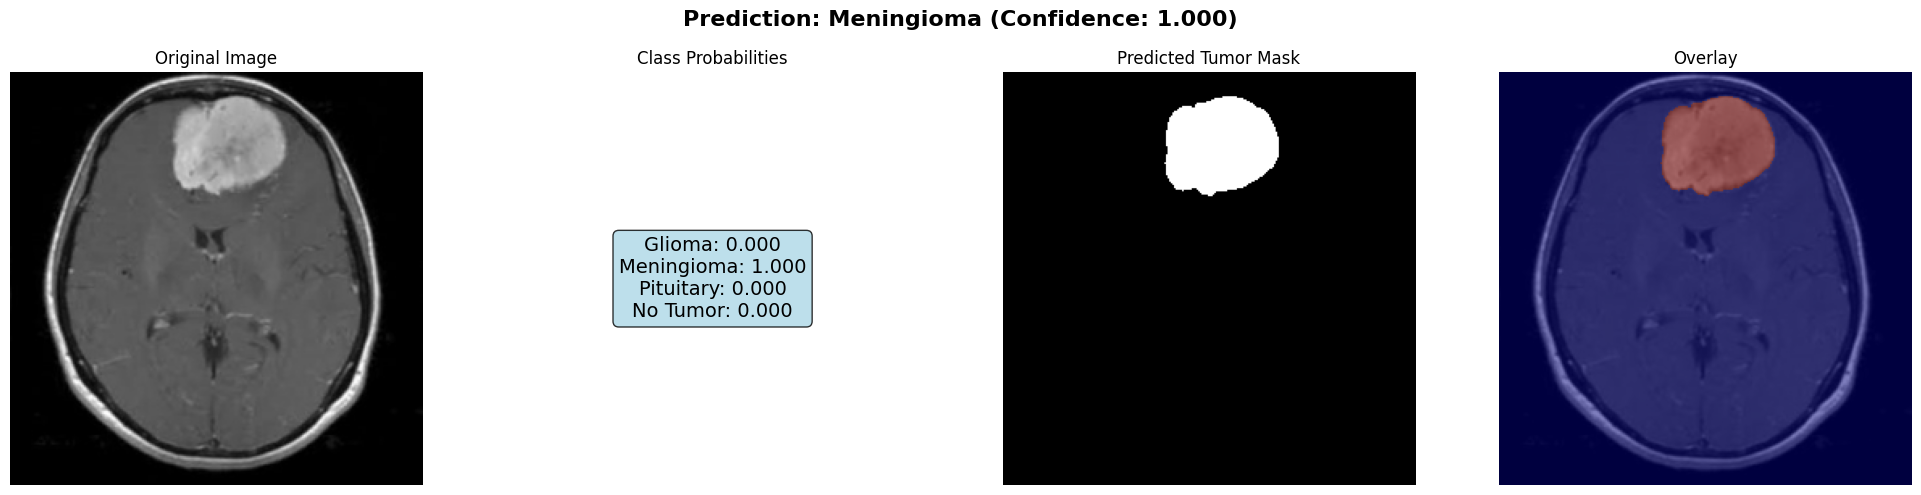


Predicted Class: Meningioma
Confidence: 1.000


In [13]:
def test_custom_image(model, image_path, device):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_img = image.copy()

    transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred_mask_logits, pred_class_logits = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask_logits).cpu().numpy()[0, 0]
        pred_class = torch.argmax(pred_class_logits, dim=1).item()
        pred_probs = torch.softmax(pred_class_logits, dim=1)[0].cpu().numpy()


    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    disp_img = inv_normalize(transformed['image']).permute(1, 2, 0).numpy()
    disp_img = np.clip(disp_img, 0, 1)


    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    prob_text = "\n".join([f"{INV_CLASS_MAP[i]}: {pred_probs[i]:.3f}"
                           for i in range(4)])

    plt.suptitle(f"Prediction: {INV_CLASS_MAP[pred_class]} "
                 f"(Confidence: {pred_probs[pred_class]:.3f})",
                 fontsize=16, fontweight='bold')

    axes[0].imshow(cv2.resize(original_img, (IMG_SIZE, IMG_SIZE)))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].text(0.5, 0.5, prob_text, ha='center', va='center',
                 fontsize=14, transform=axes[1].transAxes,
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1].set_title("Class Probabilities")
    axes[1].axis('off')

    axes[2].imshow(pred_mask > 0.5, cmap='gray')
    axes[2].set_title("Predicted Tumor Mask")
    axes[2].axis('off')

    axes[3].imshow(disp_img)
    axes[3].imshow(pred_mask > 0.5, cmap='jet', alpha=0.5)
    axes[3].set_title("Overlay")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    return INV_CLASS_MAP[pred_class], pred_probs

custom_path = "/content/2_meningioma.jpg"
predicted_class, probabilities = test_custom_image(model_standard, custom_path, DEVICE)

print(f"\nPredicted Class: {predicted_class}")
print(f"Confidence: {probabilities.max():.3f}")

In [10]:
# print("Training Attention U-Net (Joint Mode)...")
# model_attention = CustomUNet(attention=True).to(DEVICE)
# history_attention = train_model(model_attention, train_loader, cls_train_loader, val_loader, epochs=5)


# epochs_range = range(1, len(history_attention['train_loss']) + 1)

# plt.figure(figsize=(15, 10))

# # Loss
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, history_attention['train_loss'], label='Train Loss', marker='o')
# plt.plot(epochs_range, history_attention['val_loss'], label='Val Loss', marker='o')
# plt.title('Attention U-Net: Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# # Classification Accuracy
# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, history_attention['train_acc'], label='Train Acc', marker='o')
# plt.plot(epochs_range, history_attention['val_acc'], label='Val Acc', marker='o')
# plt.title('Attention U-Net: Classification Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# # Segmentation Metrics (IoU & Dice)
# plt.subplot(2, 2, 3)
# plt.plot(epochs_range, history_attention['val_iou'], label='mIoU', color='purple', marker='s')
# plt.plot(epochs_range, history_attention['val_dice'], label='Dice Coeff', color='green', marker='s')
# plt.plot(epochs_range, history_attention['val_pix_acc'], label='Pixel Acc', color='orange', linestyle='--')
# plt.title('Attention U-Net: Segmentation Metrics')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True)

# # Classification Metrics (Prec/Recall/F1)
# plt.subplot(2, 2, 4)
# plt.plot(epochs_range, history_attention['val_cls_prec'], label='Precision', color='red')
# plt.plot(epochs_range, history_attention['val_cls_recall'], label='Recall', color='blue')
# plt.plot(epochs_range, history_attention['val_cls_f1'], label='F1 Score', color='black', linewidth=2)
# plt.title('Attention U-Net: Classification Details')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# print("\n--- Confusion Matrix (Attention U-Net) ---")
# model_attention.eval()

# y_true = []
# y_pred = []

# with torch.no_grad():
#     for imgs, _, labels, _ in val_loader:
#         imgs = imgs.to(DEVICE)
#         labels = labels.to(DEVICE)

#         _, class_logits = model_attention(imgs)
#         preds = torch.argmax(class_logits, dim=1)

#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(preds.cpu().numpy())

# cm = confusion_matrix(y_true, y_pred)

# plt.figure(figsize=(8, 6))

# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=INV_CLASS_MAP.values(),
#     yticklabels=INV_CLASS_MAP.values()
# )

# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix (Attention U-Net Validation)")
# plt.show()

# print("Final Evaluation Metrics (Epoch 10) - Attention U-Net:")
# print(f"Segmentation > mIoU: {history_attention['val_iou'][-1]:.4f} | Dice: {history_attention['val_dice'][-1]:.4f}")
# print(f"Classification > Acc: {history_attention['val_acc'][-1]:.4f} | F1: {history_attention['val_cls_f1'][-1]:.4f}")

In [ ]:
#torch.save(model_attention.state_dict(), "unet_attention_jointwo.pth")
model_attention = CustomUNet(attention=True).to(DEVICE)
model_attention.load_state_dict(torch.load("/content/drive/MyDrive/unet_attention_jointw2.pth", map_location=torch.device('cpu')))
model_attention.eval()

CustomUNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

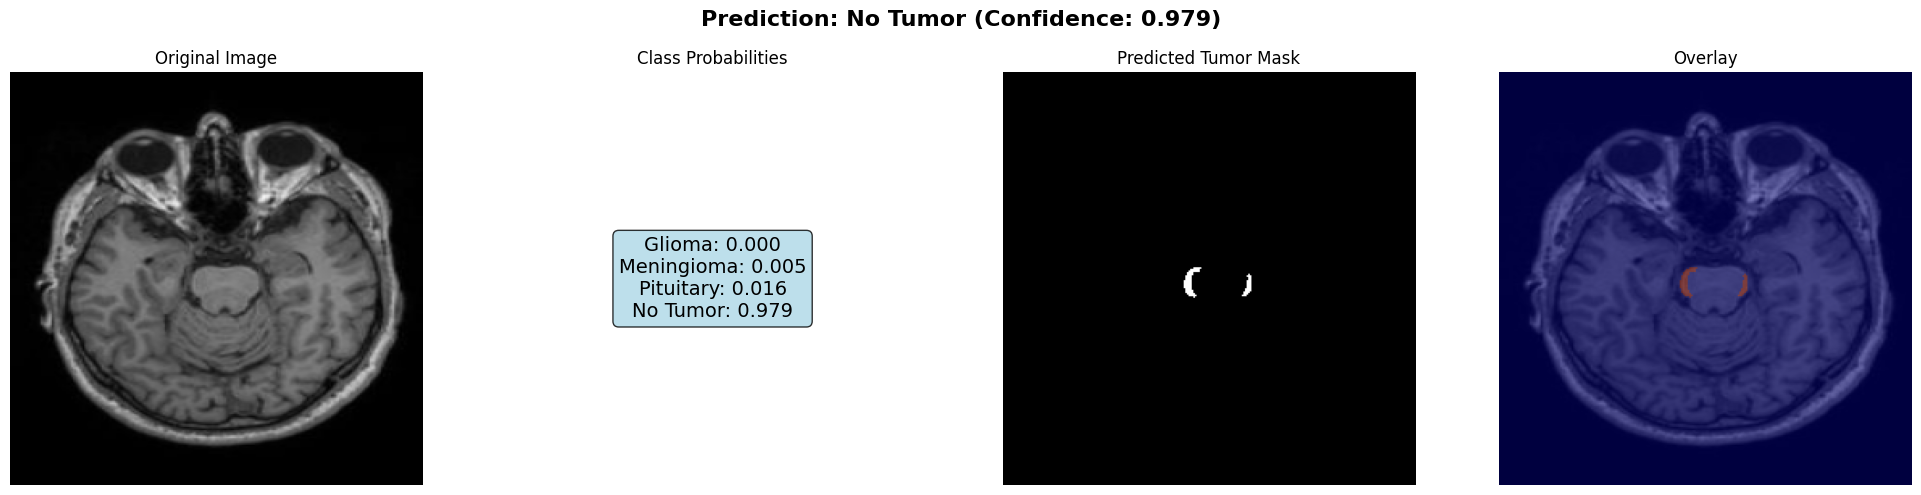


Predicted Class: No Tumor
Confidence: 0.979


In [14]:
def test_custom_image(model, image_path, device):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_img = image.copy()

    transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        pred_mask_logits, pred_class_logits = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask_logits).cpu().numpy()[0, 0]
        pred_class = torch.argmax(pred_class_logits, dim=1).item()
        pred_probs = torch.softmax(pred_class_logits, dim=1)[0].cpu().numpy()


    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    disp_img = inv_normalize(transformed['image']).permute(1, 2, 0).numpy()
    disp_img = np.clip(disp_img, 0, 1)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    prob_text = "\n".join([f"{INV_CLASS_MAP[i]}: {pred_probs[i]:.3f}"
                           for i in range(4)])

    plt.suptitle(f"Prediction: {INV_CLASS_MAP[pred_class]} "
                 f"(Confidence: {pred_probs[pred_class]:.3f})",
                 fontsize=16, fontweight='bold')

    axes[0].imshow(cv2.resize(original_img, (IMG_SIZE, IMG_SIZE)))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].text(0.5, 0.5, prob_text, ha='center', va='center',
                 fontsize=14, transform=axes[1].transAxes,
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1].set_title("Class Probabilities")
    axes[1].axis('off')

    axes[2].imshow(pred_mask > 0.5, cmap='gray')
    axes[2].set_title("Predicted Tumor Mask")
    axes[2].axis('off')

    axes[3].imshow(disp_img)
    axes[3].imshow(pred_mask > 0.5, cmap='jet', alpha=0.5)
    axes[3].set_title("Overlay")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    return INV_CLASS_MAP[pred_class], pred_probs

custom_path = "/content/3_no.jpg"
predicted_class, probabilities = test_custom_image(model_attention, custom_path, DEVICE)

print(f"\nPredicted Class: {predicted_class}")
print(f"Confidence: {probabilities.max():.3f}")